# show some basic maps


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
np.random.seed(123)

# Load Data

In [2]:
data = pd.read_csv(r'./data/data.csv')
data.columns = ['index', 'yearsInBusiness', 'rAssets', 'rIntang', 'rNOI', 'rating010',
       'NACE_division', 'staff_count', 'staff_turnover', 'staff_variation',
       'lat', 'lon']
# data['lat'] = data['lat'].astype(float)
# data['lon'] = data['lon'].astype(float)
data.head(3)

,index,yearsInBusiness,rAssets,rIntang,rNOI,rating010,NACE_division,staff_count,staff_turnover,staff_variation,lat,lon
0,1388,24.5,1.961213,1.128333,0.075187,6.0,36,0,29,5,45.649961,13.768875
1,1436,22.1,8.169555,0.289103,0.411161,5.0,69,0,35,-1,45.651428,13.780139
2,550,91.8,8.822509,0.008391,0.225178,5.0,28,1,9,9,46.191657,13.199971


# Data Exploration

In [3]:
def plot_clusters(X, cluster_labels, title=""):
    for i in np.unique(cluster_labels):
        cluster_points = X[cluster_labels == i , :]       
        if i == 0: 
            ax.scatter(cluster_points[:,0] , cluster_points[:,1] , color="yellow", marker='.', s=2)
        else:
            ax.scatter(cluster_points[:,0] , cluster_points[:,1] , cmap = i, marker='o', s=2)
    ax.set_title(title, fontweight='bold')
    return

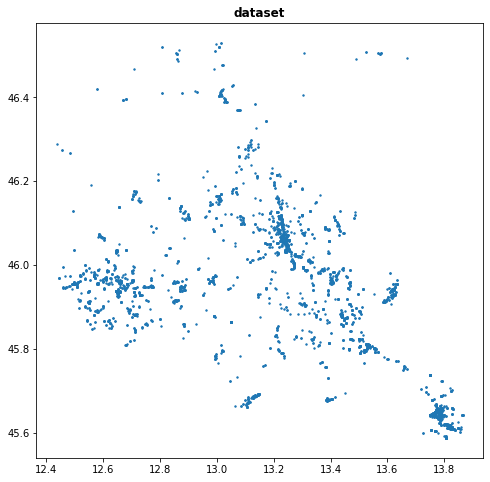

In [4]:
X = np.array(data[ ['lon','lat'  ] ]) 
n, p  = X.shape
_, ax = plt.subplots(figsize=(8,8))
plot_clusters(X, np.ones(n), title = "dataset")
plt.show()


## Scaling factor

In [5]:
# approximated, valid only at short distances but good enough to give a rougn idea of epsilon
R = 6371 #earth radius
lon1, lat1,  =  12.6, 46.0
lon2, lat2   =  13.8, 46.0
# longitude x
dx = R*(lon2-lon1)*np.cos(lat1)*np.pi/180
# latitude y
dy = R* (lat2-lat1)*np.pi/180
d =  np.sqrt(dx**2 +  dy**2)
dx, dy

(-57.66719385463093, 0.0)

In [6]:
lon1, lat1,  =  13.2, 45.6
lon2, lat2   =  13.2, 46.6
# longitude x
dx = R*(lon2-lon1)*np.cos(lat1)*np.pi/180
# latitude y
dy = R* (lat2-lat1)*np.pi/180
d =  np.sqrt(dx**2 +  dy**2)
dx, dy

(-0.0, 111.19492664455873)

In [7]:
# TODO add scaling factor 57,111 to have more "readable" values of epsilon in km

## calculate density for each point
X = data points = company position
G = grid points equally spaced

In [8]:
grid = pd.read_csv(r'./maps/FVG/FVG_grid.csv')
nbins=np.sqrt(grid.shape[0]).astype(int)
xi = np.array(grid.x).reshape(nbins,nbins)
yi = np.array(grid.y).reshape(nbins,nbins)
G =  np.array(grid)

# calculate distance matrix

In [9]:
dm = distance_matrix(G,X)
n_data_points= X.shape[0]
n_grid_points=G.shape[0]
n_reshape = np.sqrt(n_grid_points).astype(int)


In [10]:
def epsilon_neighborhood(dm, X, g, epsilon):
    """
    dm: distance_matrix(G,X)
    g: point of the grid G
    returns eps_neighb a list of indices of X that are within a distance epsilon of point G
    """
    distances = dm[g]
    eps_neighb = np.where(X[ (distances < epsilon) ])[0]
    number_of_neighb = len(eps_neighb)
    
    return number_of_neighb, eps_neighb


Given Epsilon = 0.005 and minPoints = 20, the fraction of core points is 0.0043
Given Epsilon = 0.01 and minPoints = 20, the fraction of core points is 0.02
Given Epsilon = 0.02 and minPoints = 20, the fraction of core points is 0.0757
Given Epsilon = 0.05 and minPoints = 20, the fraction of core points is 0.2788
Given Epsilon = 0.08 and minPoints = 20, the fraction of core points is 0.4161


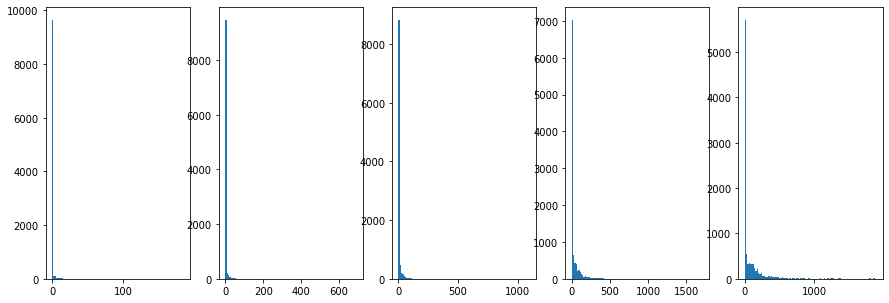

In [11]:
minPoints = 20
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (15,5))
nplot=0
for epsilon in [5e-3, 1e-2, 2e-2, 5e-2, 8e-2]:
    nn_epsilon = []
    is_core = []
    for g in range(n_grid_points):
        number_of_neighb, eps_neighb = epsilon_neighborhood(dm, X, g, epsilon)
        nn_epsilon.append(number_of_neighb)
        is_core.append( number_of_neighb > minPoints  )
    
    ax[nplot].hist(nn_epsilon, bins = 100)
    nplot+=1
    fraction_core_points = np.array(is_core).mean()
    print(f'Given Epsilon = {epsilon} and minPoints = {minPoints}, the fraction of core points is {fraction_core_points}')

select epsilon = .05, minPoints=20

# compute density

In [12]:
def compute_density(dm, X, G, epsilon):
    n_grid_points=  G.shape[0]
    n_data_points = X.shape[0]
    assert n_data_points > 0 , "size of X should be greater than 0"
    density = np.zeros(n_grid_points).astype(int)
    number_of_neighb = np.zeros(n_grid_points).astype(int)

    for g in range(n_grid_points):
        nnb, eps_neighb = epsilon_neighborhood(dm, X, g, epsilon)
        number_of_neighb[g] = nnb
    
    density = number_of_neighb/n_data_points
    
        
    return np.array(number_of_neighb), np.array(density)

In [126]:
def compute_weighted_density(dm, X, G, W, epsilon):
    n_grid_points=  G.shape[0]
    n_data_points = X.shape[0]
    assert n_data_points > 0 , "size of X should be greater than 0"
    sum_of_weights = np.zeros(n_grid_points).astype(int)
    number_of_neighb = np.zeros(n_grid_points).astype(int)

    for g in range(n_grid_points):
        nnb, eps_neighb = epsilon_neighborhood(dm, X, g, epsilon)
        number_of_neighb[g] = nnb 
        sum_of_weights[g] = np.sum(W[eps_neighb])
    
    density = sum_of_weights/n_data_points
    
        
    return np.array(number_of_neighb), np.array(density)

In [13]:
epsilon=1e-2
nn, dG1 = compute_density(dm, X, G,  epsilon=epsilon)


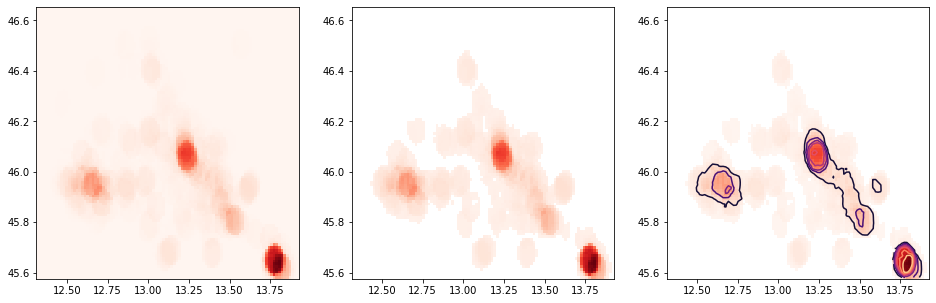

In [14]:

fig, (ax1,ax2, ax3) = plt.subplots(figsize=(16,5), nrows=1, ncols=3)
nn, dG1 = compute_density(dm, X, G, epsilon=0.06)

cmap="Reds"
n_reshape = 100
dG1r = dG1.reshape((n_reshape,n_reshape))

ax1.pcolormesh(xi, yi, dG1r,shading='nearest', cmap=cmap)

threshold=epsilon
dG1rM = np.ma.masked_array(dG1r, dG1r <threshold)
ax2.pcolormesh(xi, yi, dG1rM, shading='auto', cmap=cmap, vmin=0)

ax3.pcolormesh(xi, yi, dG1rM, shading='auto', cmap=cmap, alpha = 1, zorder = 1)
ax3.contour(xi, yi, dG1rM, cmap="magma", vmin=threshold, zorder = 3)

plt.show()


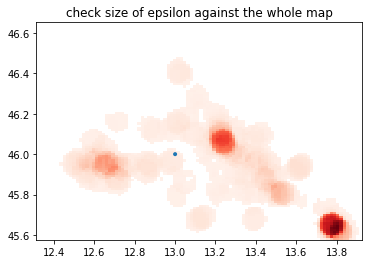

In [15]:
figure, axes = plt.subplots() 
cc = plt.Circle( (13,46), epsilon)
plt.pcolormesh(xi, yi, dG1rM, shading='auto', cmap=cmap, vmin=0)

axes.set_aspect( 1 ) 
axes.add_artist( cc ) 
plt.title( 'check size of epsilon against the whole map' ) 
plt.show()

In [150]:
def plot_map(df, color_fill = "green", alpha = .2, color_border= "gray" , linewidth = .8):
    for _, row in df.iterrows():
        x, y = list(zip(*row.poly)) 
        plt.fill(x,y, color = color_fill, alpha = alpha, zorder=1)
        plt.plot(x,y, color = color_border, linewidth=linewidth, zorder=2)
        


In [139]:
#load data from file
ita = pd.read_json(r'./maps/FVG/FVG_mappa.json', orient='records')
# filter a single region
fvg=ita[ ita.istat_r==6]
# plot the map


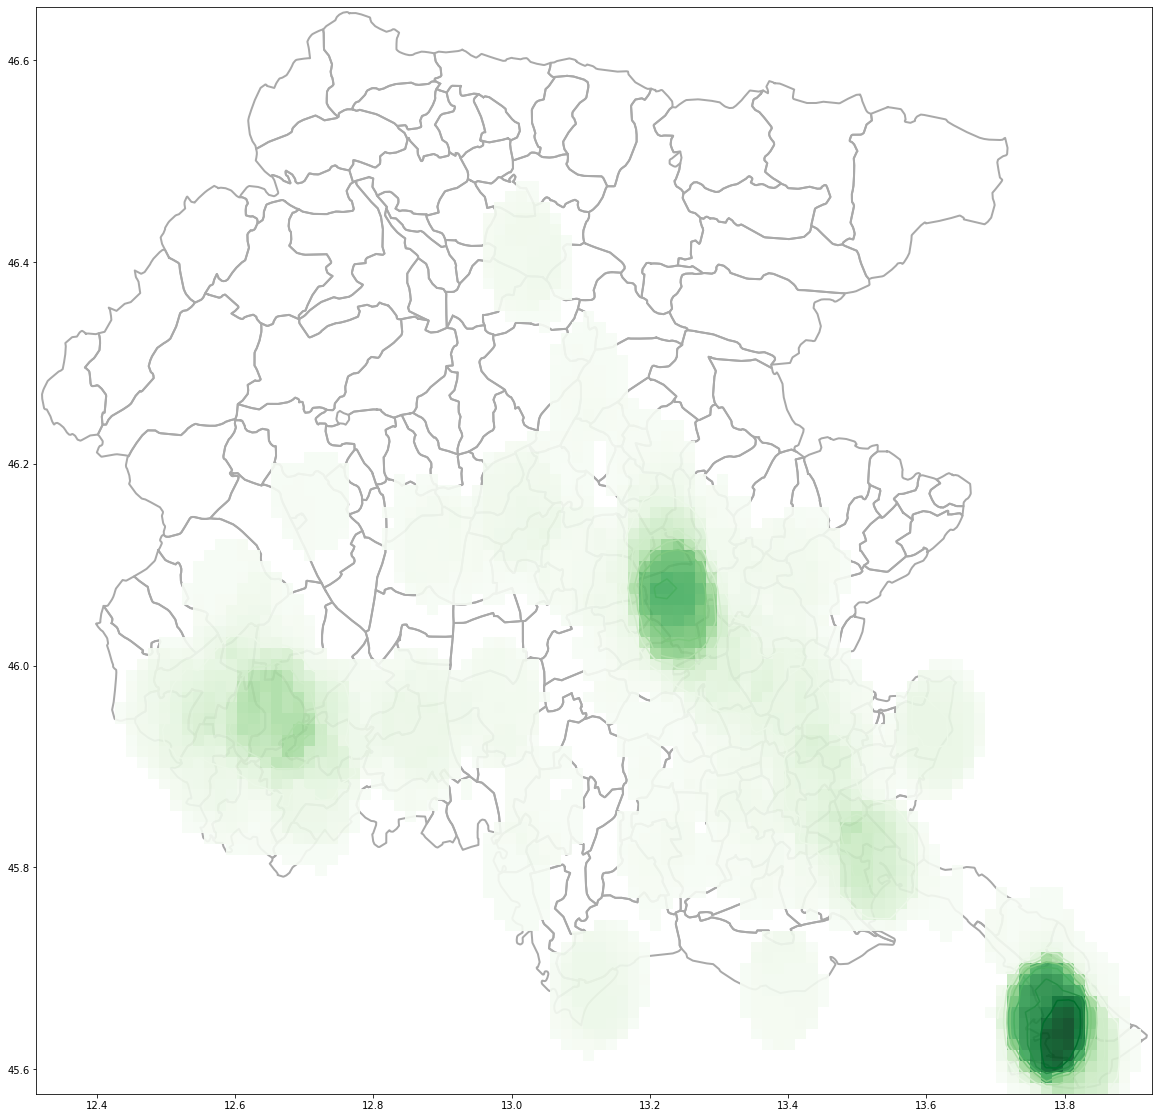

In [163]:
fig, ax = plt.subplots(figsize=(20,20))

plot_map(fvg, color_fill = "white", alpha = 1, color_border= "darkgray" , linewidth = 2)
plt.pcolormesh(xi, yi, dG1rM, shading='auto', cmap="Greens",alpha = .9, zorder = 3)
plt.contour(xi, yi, dG1rM, cmap="Greens", vmin=threshold, zorder = 4)
plt.show()

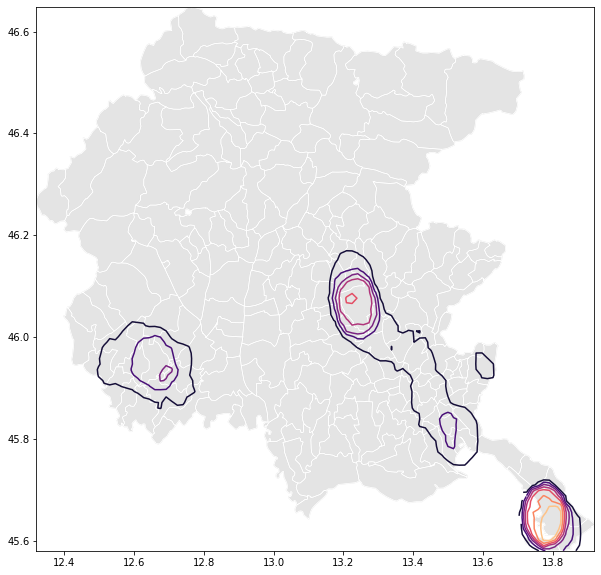

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
plot_map(fvg, color_fill = "lightgray", alpha = .6, color_border= "white" , linewidth = .8)
plt.contour(xi, yi, dG1rM, cmap="magma", vmin=threshold, zorder = 4)

plt.show()

## other data points

In [20]:
data.columns

Index(['index', 'yearsInBusiness', 'rAssets', 'rIntang', 'rNOI', 'rating010',
       'NACE_division', 'staff_count', 'staff_turnover', 'staff_variation',
       'lat', 'lon'],
      dtype='object')

In [65]:
dd = data[ ['lon', 'lat', 'staff_count'] ]
dd.columns = ['x','y','z']
D = np.array(dd[ ['x','y' ] ]) 
D.shape

(4563, 2)

## a simple bubble plot


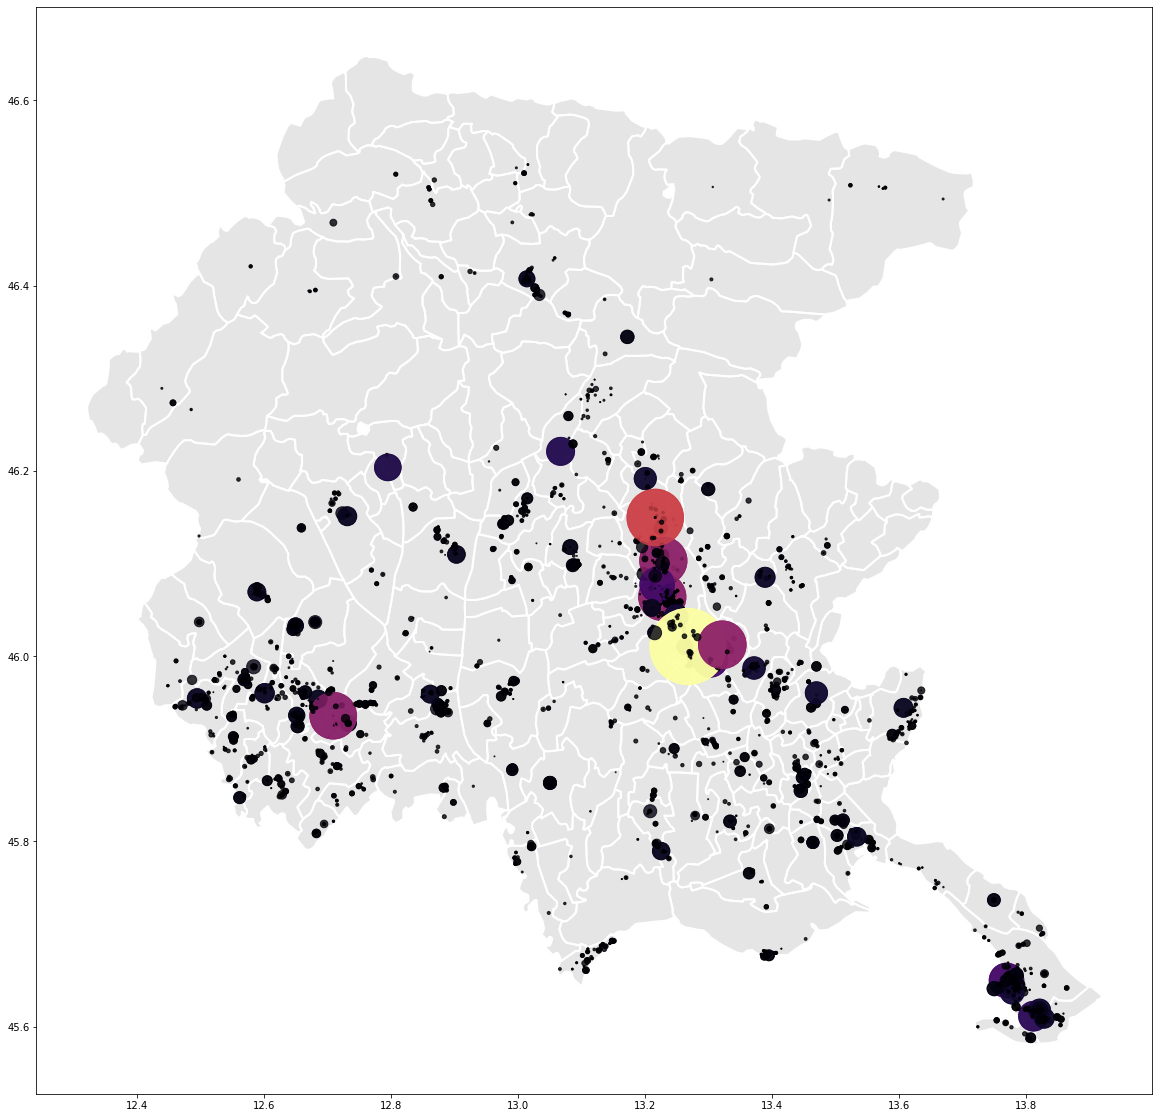

In [73]:
fig, ax = plt.subplots(figsize=(20,20))
plot_map(fvg, color_fill = "gray", alpha = .2, color_border= "white" , linewidth = 2)
plt.scatter(dd.x,dd.y, s=dd.z, c = dd.z, alpha = .8, cmap = "inferno", zorder = 5)

## density

In [121]:
dm = distance_matrix(G,D)
n_data_points= D.shape[0]
n_grid_points= G.shape[0]
n_reshape = np.sqrt(n_grid_points).astype(int)

In [132]:
epsilon=2e-2
W = np.array(dd.z)
nn, dens = compute_weighted_density(dm, X, G, W, epsilon=epsilon)
#dens_r = dens.reshape((n_reshape,n_reshape))
 
dens

array([0., 0., 0., ..., 0., 0., 0.])

In [133]:
dens.mean()

0.020144729344729346

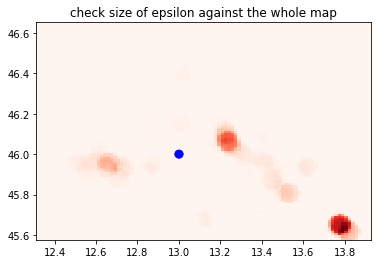

In [134]:
figure, axes = plt.subplots() 
plt.pcolormesh(xi, yi, dens_r, shading='auto', cmap='Reds', vmin=epsilon)
cc = plt.Circle( (13,46), epsilon,color = "blue")
axes.add_artist( cc ) 
plt.title( 'check size of epsilon against the whole map' ) 
plt.show()

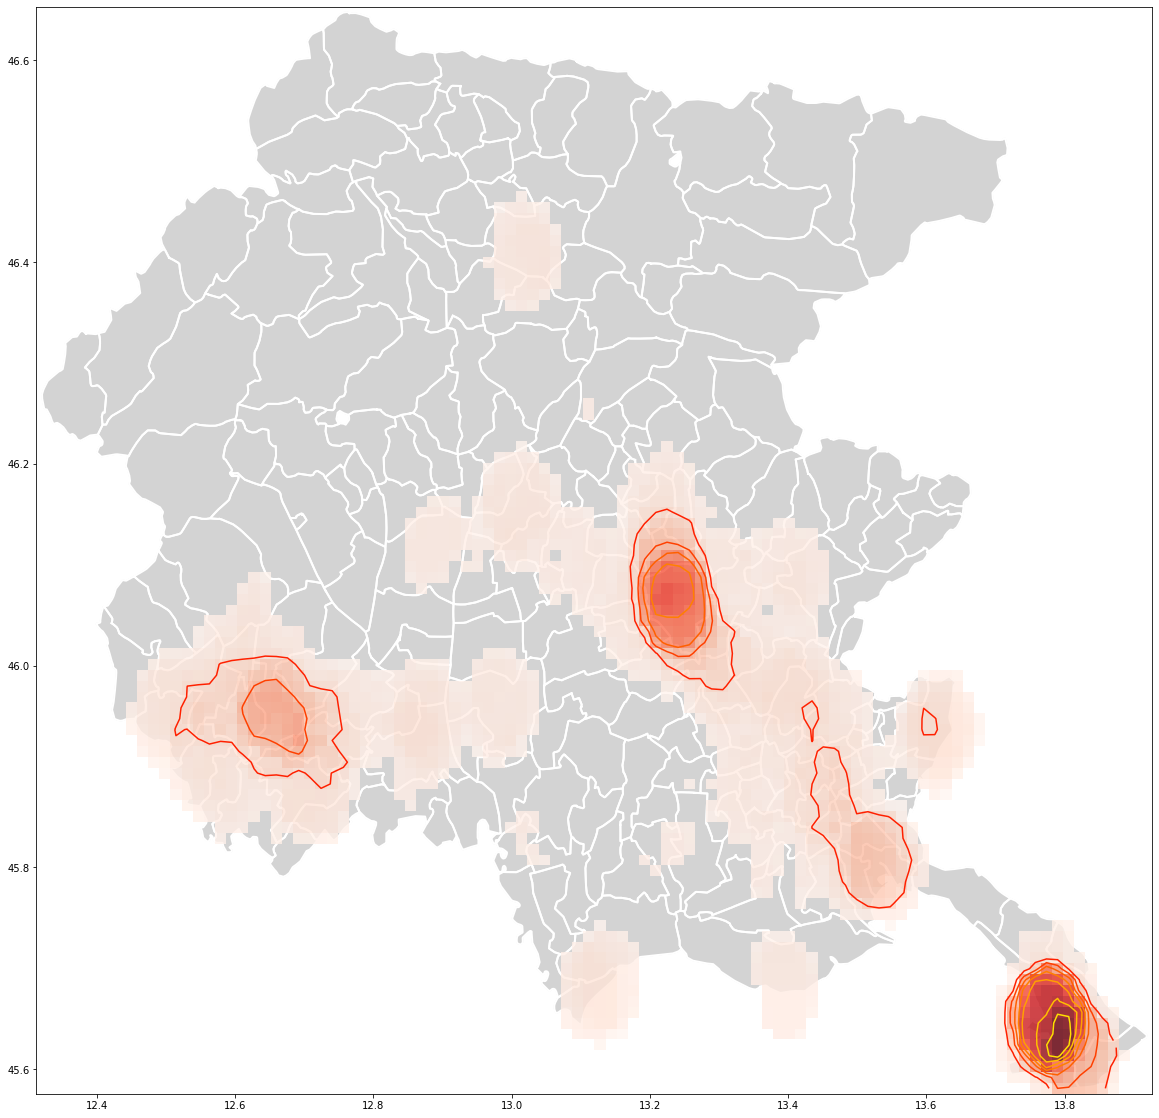

In [137]:
fig, ax = plt.subplots(figsize=(20,20))
cmap = "Greens"
plot_map(fvg, color_fill = "lightgray", alpha = 1, color_border= "white" , linewidth = 2)

threshold=epsilon
dens_r_M = np.ma.masked_array(dens_r, dG1r <threshold)
plt.pcolormesh(xi, yi, dens_r_M, shading='auto', cmap='Reds', alpha = .8, zorder = 4)

plt.contour(xi, yi, dens_r_M, cmap="autumn",  zorder = 5)

plt.show()